In [1]:
#############################################
## Fit Logistic Lasso model to MIMIC-III clinical note data --- goal to use note features to predict death in 30d from discharge
##
## Author: Chris Meaney 
## Date: January 2024
#############################################

In [2]:
###################
## Package dependencies
###################

## Numerics
import numpy as np

## Data wrangling
import pandas as pd

## For wilcoxon rank sum test
from scipy.stats import ranksums

## Various machine learning models, pre-processing, metrics, etc.
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics

## For plotting
import matplotlib.pyplot as plt

## String data
import string

## Timing processes
from time import time

## Environment characteristics
import session_info

In [5]:
## Inspect DataFrame
X.head()

,SUBJECT_ID,HADM_ID,DOB_DATE,ADMIT_DATE,DISCH_DATE,DOD_DATE,DOD_FLAG,GENDER,ADMIT_AGE,NUM_ADMIT,ICD9_CODE,ICD9_CODE_LIST,NUM_ICD9_CODE,DISCH_2_DOD_,DISCH_2_DOD_30D,DISCH_2_DOD_30D_SURVTIME,TEXT,TEXT_LEN,SHORT_TITLE,LONG_TITLE,DOD_FLAG_
0,682,188382,2036-12-26,2118-08-19,2118-09-03,2119-08-03,False,F,81.698630,1,4472,"[4472, 41071, 42830, 5990, 4280, 5849, 40391, ...",9,334.0,False,30,Admission Date: [**2118-8-19**] ...,10041,Rupture of artery,Rupture of artery,True
1,786,117381,2033-05-14,2115-12-29,2116-01-10,2116-08-31,False,M,82.679452,1,4472,"[4472, 4538, 00845, 49121, 42731, 2875, 2851, ...",9,234.0,False,30,Admission Date: [**2115-12-29**] Discharg...,14642,Rupture of artery,Rupture of artery,True
2,16181,190902,2116-07-18,2196-02-14,2196-02-17,2202-11-22,False,M,79.630137,1,4472,"[4472, 496, 4019, 4422, 53081, 3051, V173, V12...",9,2469.0,False,30,Admission Date: [**2196-2-14**] ...,10935,Rupture of artery,Rupture of artery,True
3,60809,131743,2048-08-27,2123-04-08,2123-05-01,NaT,True,F,74.660274,1,4472,"[4472, 5849, 59382, 591, 5934, 2851, E8792, 59...",16,NaN,False,30,Admission Date: [**2123-4-8**] D...,9302,Rupture of artery,Rupture of artery,False
4,695,177128,2093-05-14,2178-08-05,2178-08-13,2178-09-16,False,F,85.282192,2,5771,"[5771, 48241, 42731, 2765, 2762, 4240, 3970, 4...",9,34.0,False,30,Admission Date: [**2178-8-5**] Discharg...,9829,Chronic pancreatitis,Chronic pancreatitis,True


In [6]:
##########################
## 
## Investgiste association between potential features on outcome (death within 30d of discharge)
##
##########################

In [7]:
## 3% of persons in the cohort die <30d following discharge
X.DISCH_2_DOD_30D.value_counts(normalize=True, dropna=False)

False    0.970015
True     0.029985
Name: DISCH_2_DOD_30D, dtype: float64

In [8]:
## Distirbution of age for each outcome strata
X.groupby('DISCH_2_DOD_30D').ADMIT_AGE.describe().unstack(0)

       DISCH_2_DOD_30D
count  False              20542.000000
       True                 635.000000
mean   False                 60.257211
       True                  73.220753
std    False                 17.636499
       True                  12.509890
min    False                 18.008219
       True                  25.197260
25%    False                 48.613699
       True                  66.871233
50%    False                 62.008219
       True                  76.605479
75%    False                 74.679452
       True                  83.389041
max    False                 89.060274
       True                  89.008219
dtype: float64

In [9]:
## Distribution of sex in each outcome strata
pd.crosstab(X.GENDER, X.DISCH_2_DOD_30D, normalize='columns')

DISCH_2_DOD_30D,False,True
GENDER,,
F,0.421186,0.456693
M,0.578814,0.543307


In [10]:
## Distribution of the number of previous admissions in each outcome strata
pd.crosstab(X.NUM_ADMIT-1, X.DISCH_2_DOD_30D, normalize='columns').head(5)

DISCH_2_DOD_30D,False,True
NUM_ADMIT,,
0,0.815695,0.748031
1,0.128615,0.168504
2,0.032178,0.056693
3,0.012122,0.007874
4,0.005404,0.009449


In [11]:
## Distribution of text length in each outcome strata
X.groupby('DISCH_2_DOD_30D').TEXT_LEN.describe().unstack(0)

       DISCH_2_DOD_30D
count  False              20542.000000
       True                 635.000000
mean   False              11476.193847
       True               12586.278740
std    False               5520.215231
       True                5889.831360
min    False                528.000000
       True                 587.000000
25%    False               7619.250000
       True                8792.000000
50%    False              10525.000000
       True               11488.000000
75%    False              14159.000000
       True               15181.000000
max    False              54350.000000
       True               46332.000000
dtype: float64

In [12]:
######################
## Tokenize the discharge note using simple whitespace tokenizer; 
######################

In [13]:
## Create stop word lists
my_additional_stop_words = string.ascii_lowercase
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words) ## Add single letters to stop-word list

## Construct DTM of unigram tokens
t0 = time()

#vectorizer = CountVectorizer()
vectorizer = CountVectorizer(lowercase=True,
                            stop_words='english',
                            ngram_range=(1,2),
                            analyzer='word',
                            token_pattern="[a-zA-Z]{2,}" ## Remove digits from token patterns
                            )

dtm_unigram = vectorizer.fit_transform(X.TEXT)

t1 = time()
t1-t0

38.00500011444092

In [14]:
##
## Grab a tokenizer from NLTK --- notice that this is much slower than simple sklearn tokenizer
##

## from nltk.tokenize import TreebankWordTokenizer
## import re

## Construct DTM of unigram tokens
## t0 = time()

## vectorizer = CountVectorizer(lowercase=True,
##                            stop_words='english',
##                            ngram_range=(1,1),
##                            tokenizer=TreebankWordTokenizer().tokenize
##                            )

## dtm_unigram = vectorizer.fit_transform(X.TEXT)

## t1 = time()
## t1-t0

In [15]:
## Note: you can provide a user-specified VOCABULARY using the syntax below
##
## vocabulary --- Mapping or iterable, default=None
## Either a Mapping (e.g., a dict) where keys are terms and values are indices in the feature matrix, or an iterable over terms. If not given, a vocabulary is determined from the input documents. Indices in the mapping should not be repeated and should not have any gap between 0 and the largest index.

In [16]:
dtm_unigram.shape

(21177, 88086)

In [17]:
vocab = vectorizer.get_feature_names_out()
len(vocab)

88086

In [18]:
## Get lists of words/tokens and associated frequency statistics
word_list = vectorizer.get_feature_names_out() 
count_list = np.asarray(dtm_unigram.sum(axis=0))

In [19]:
word_freq_df = pd.DataFrame({
                            'token': word_list,
                            'freq': count_list.ravel()
                            })

word_freq_df = word_freq_df.sort_values('freq', ascending=False)
word_freq_df.head(50)

,token,freq
48348,mg,330808
77753,tablet,265360
57619,patient,237774
60490,po,201543
9477,blood,198811
22148,discharge,174979
36313,hospital,174439
19121,daily,164482
72373,sig,162623
19291,day,150377


In [20]:
# vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
# X2 = vectorizer2.fit_transform(corpus)
# vectorizer2.get_feature_names_out()

In [21]:
# t0 = time()
#
# vectorizer = CountVectorizer()
# vectorizer2 = CountVectorizer(lowercase=True,
#                            stop_words='english',
#                            ngram_range=(2,2),
#                            analyzer='word'
#                            )
#
# dtm_bigram = vectorizer2.fit_transform(X.TEXT)
#
# t1 = time()
# t1-t0

In [22]:
# dtm_bigram.shape

In [23]:
## Get lists of bigrams and associated frequency statistics
# word_list = vectorizer2.get_feature_names_out() 
# count_list = np.asarray(dtm_bigram.sum(axis=0))
#
# word_freq_df = pd.DataFrame({
#                            'token': word_list,
#                            'freq': count_list.ravel()
#                            })
#
# word_freq_df = word_freq_df.sort_values('freq', ascending=False)
# word_freq_df.head(50)

In [24]:
# vectorizer3 = CountVectorizer(analyzer='word', ngram_range=(3, 3))
# X3 = vectorizer3.fit_transform(corpus)
# vectorizer3.get_feature_names_out()

In [25]:
# t0 = time()
#
# vectorizer = CountVectorizer()
# vectorizer3 = CountVectorizer(lowercase=True,
#                            stop_words='english',
#                            ngram_range=(3,3),
#                            analyzer='word'
#                            )
#
# dtm_trigram = vectorizer3.fit_transform(X.TEXT)
#
# t1 = time()
# t1-t0

In [26]:
# dtm_trigram.shape

In [27]:
## Get lists of trigrams and associated frequency statistics
# word_list = vectorizer3.get_feature_names_out() 
# count_list = np.asarray(dtm_trigram.sum(axis=0))
#
# word_freq_df = pd.DataFrame({
#                            'token': word_list,
#                            'freq': count_list.ravel()
#                            })
#
# word_freq_df = word_freq_df.sort_values('freq', ascending=False)
# word_freq_df.head(50)

In [28]:
###############################
##
## Create train/test datasets for predicting death within 30d of discharge
##
###############################

In [29]:
X_train, X_test, y_train, y_test = train_test_split(dtm_unigram, X.DISCH_2_DOD_30D, test_size=0.33, random_state=42)

In [30]:
[X_train.shape, X_test.shape, y_train.shape, y_test.shape]

[(14188, 88086), (6989, 88086), (14188,), (6989,)]

In [31]:
###############################
##
## Using training data set, empirically which words/tokens are most correlated with the death within 30d discharge outcome
##
###############################

In [32]:
X_train.shape

(14188, 88086)

In [33]:
tok_list = []
wilcoxon_list = []
pval_list = []

t0_assoc = time()

for col in range(X_train.shape[1]):
    ## Grab data
    x = X_train[:, col].toarray()
    y = y_train
    x_y0 = x[y==False]
    x_y1 = x[y==True]
    ## Store word
    tok = word_list[col]
    tok_list.append(tok)
    ## Wilcoxon stat
    wilcoxon = ranksums(x_y0, x_y1)[0]
    wilcoxon_list.append(wilcoxon)
    ## Pvalue
    pval = ranksums(x_y0, x_y1)[1]
    pval_list.append(pval)

t1_assoc = time()
time_assoc = t1_assoc - t0_assoc

## Put vectors into a pandas dataframe
bivar_assoc_df = pd.DataFrame({'token': tok_list,
                              'wilcox': wilcoxon_list,
                              'pval': pval_list
                              })

In [34]:
time_assoc

7700.208699941635

In [35]:
## Top unigram words/tokens most assocated with outcome: death 30d from discharge
num_words = 50

bivar_assoc_df = bivar_assoc_df.sort_values(['pval'], ascending=True)
bivar_assoc_df.head(num_words)

,token,wilcox,pval
11874,care,[-12.68065690535487],[7.569480683188226e-37]
36307,hospice,[-11.750369680217727],[7.031057709694979e-32]
31064,follow,[11.6339019833298],[2.7713340029772684e-31]
23078,dnr,[-11.37014394623571],[5.88903896270201e-30]
5065,appointment,[11.266077126426497],[1.929776163724416e-29]
29279,family,[-10.640568986403478],[1.9294745675552148e-26]
15511,comfort,[-10.543666186798522],[5.433839327294423e-26]
23072,dni,[-10.333096660611062],[4.992240322396064e-25]
29184,failure,[-10.310611093436965],[6.309881244393634e-25]
78495,telephone,[9.951667945792742],[2.4799138722021917e-23]


In [36]:
###############################
##
## Lasso regression...on DTM features to predict death within 30d of discharge
##
###############################

In [37]:
## Lasso regression model
clf = linear_model.LogisticRegression(penalty='l1',
                                      C=1,
                                      solver='liblinear'
                                      )
clf.fit(X_train, y_train)

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [38]:
## Print Lasso intercept coefficient
print(clf.intercept_)

[-1.84190931]


In [39]:
## Print Lasso regression coefficient
print(clf.coef_)

[[0.         0.17484725 0.         ... 0.         0.         0.        ]]


In [40]:
## Dataframe of lasso regression coefficients
lasso_coefs = pd.DataFrame({
                    'token': vectorizer.get_feature_names_out(),
                    'coef': clf.coef_[0],
})

lasso_coefs = lasso_coefs.sort_values('coef', ascending=False)
lasso_coefs.head(50)

,token,coef
24433,dyspneic,1.281286
31137,fondaparinox,1.250084
66499,regards,1.134641
42530,jaundiced,1.001835
58352,pericardectomy,0.933557
84094,urostomy,0.920197
25231,elderly,0.903997
14797,cmo,0.876735
25770,empiric,0.872515
29001,eyedrops,0.853310


In [41]:
## Number of non-zero lasso regression coefficients
np.sum(lasso_coefs.coef>0)

680

In [42]:
##
## Evaluate model on training dataset
##

In [43]:
y_train.value_counts()

False    13759
True       429
Name: DISCH_2_DOD_30D, dtype: int64

In [44]:
pred_train = clf.predict_proba(X_train)[:,1]
pd.Series(pred_train).describe()

count    1.418800e+04
mean     3.032200e-02
std      1.550703e-01
min      1.224455e-21
25%      7.169425e-07
50%      3.176206e-05
75%      8.227126e-04
max      9.999998e-01
dtype: float64

<AxesSubplot:>

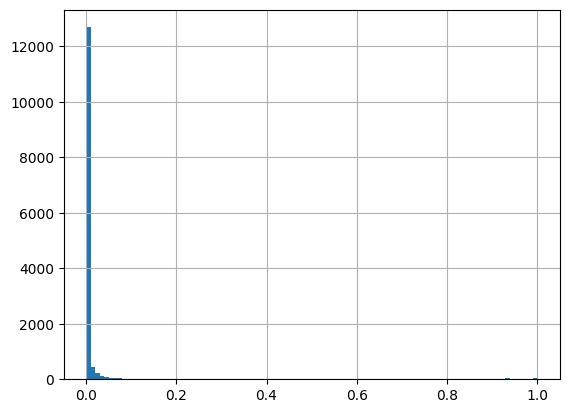

In [45]:
pd.Series(pred_train).hist(bins=100)

In [46]:
## Evaluate model quality using AUC metric
fpr, tpr, thresholds = metrics.roc_curve(y_train, pred_train, pos_label=True)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.9999972893351773

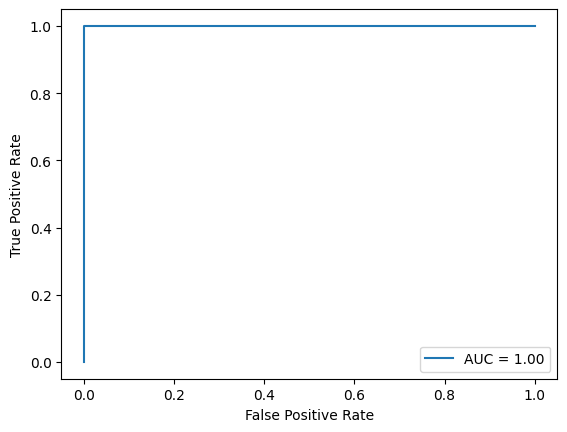

In [47]:
## Plot ROC curve
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

In [48]:
##
## Evaluate model on test dataset
##

In [49]:
pred_test = clf.predict_proba(X_test)[:,1]

In [50]:
pd.Series(pred_test).describe()

count    6.989000e+03
mean     2.830653e-02
std      1.320782e-01
min      5.440356e-19
25%      8.079241e-07
50%      3.303844e-05
75%      8.479974e-04
max      1.000000e+00
dtype: float64

<AxesSubplot:>

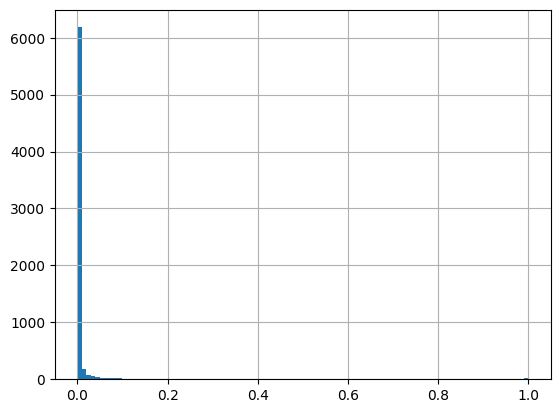

In [51]:
pd.Series(pred_test).hist(bins=100)

In [52]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test, pos_label=True)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.8157222009907694

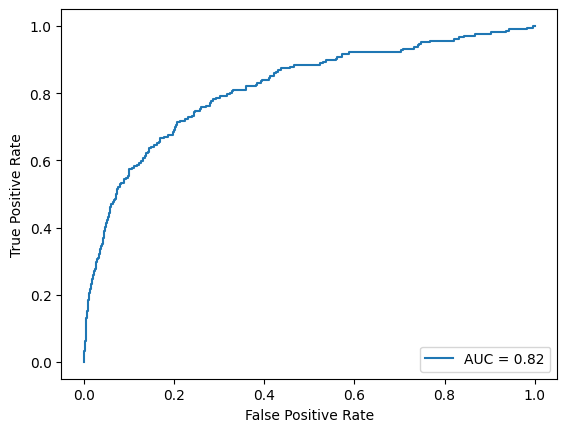

In [53]:
## Plot ROC curve
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

In [54]:
######################
## Notebook Environment
######################

In [55]:
session_info.show()